In [1]:
import numpy as np
import matplotlib.pyplot as plt
import keras
from keras.models import Sequential
from keras.optimizers import Adam
from keras.utils.np_utils import to_categorical
from keras.layers import Dense, Dropout, Flatten
from keras.layers.convolutional import Conv2D, MaxPooling2D
import pickle
import pandas as pd
import random
np.random.seed(0)

Using TensorFlow backend.


In [2]:
!git clone https://bitbucket.org/jadslim/german-traffic-signs # Get data

Cloning into 'german-traffic-signs'...
remote: Counting objects: 6, done.
remote: Compressing objects: 100% (6/6), done.
remote: Total 6 (delta 0), reused 0 (delta 0)
Unpacking objects: 100% (6/6), done.


In [3]:
!ls german-traffic-signs/ # List all files

signnames.csv  test.p  train.p	valid.p


In [4]:
# Unpickle Data
with open('german-traffic-signs/train.p', 'rb') as f: # read the pickle file in binary
  train_data = pickle.load(f)

with open('german-traffic-signs/valid.p', 'rb') as f: # read the pickle file in binary
  val_data = pickle.load(f)
  
with open('german-traffic-signs/test.p', 'rb') as f: # read the pickle file in binary
  test_data = pickle.load(f)
  
print(type(train_data))

X_train, y_train = train_data['features'], train_data['labels']
X_val, y_val = val_data['features'], val_data['labels']
X_test, y_test = test_data['features'], test_data['labels']

<class 'dict'>


In [5]:
# Analyze the Data
print(X_train.shape)
print(X_val.shape)
print(X_test.shape)

(34799, 32, 32, 3)
(4410, 32, 32, 3)
(12630, 32, 32, 3)


In [0]:
# Print errors if input data is not correct
assert(X_train.shape[0] == y_train.shape[0]), 'The number of images is not equel to the number of labels'
assert(X_val.shape[0] == y_val.shape[0]), 'The number of images is not equel to the number of labels'
assert(X_test.shape[0] == y_test.shape[0]), 'The number of images is not equel to the number of labels'
assert(X_train.shape[1:] == (32, 32, 3)), 'The dimensions of the images are not 32 x 32 x 3'
assert(X_val.shape[1:] == (32, 32, 3)), 'The dimensions of the images are not 32 x 32 x 3'
assert(X_test.shape[1:] == (32, 32, 3)), 'The dimensions of the images are not 32 x 32 x 3'

   ClassId                     SignName
0        0         Speed limit (20km/h)
1        1         Speed limit (30km/h)
2        2         Speed limit (50km/h)
3        3         Speed limit (60km/h)
4        4         Speed limit (70km/h)
5        5         Speed limit (80km/h)
6        6  End of speed limit (80km/h)
7        7        Speed limit (100km/h)
8        8        Speed limit (120km/h)
9        9                   No passing


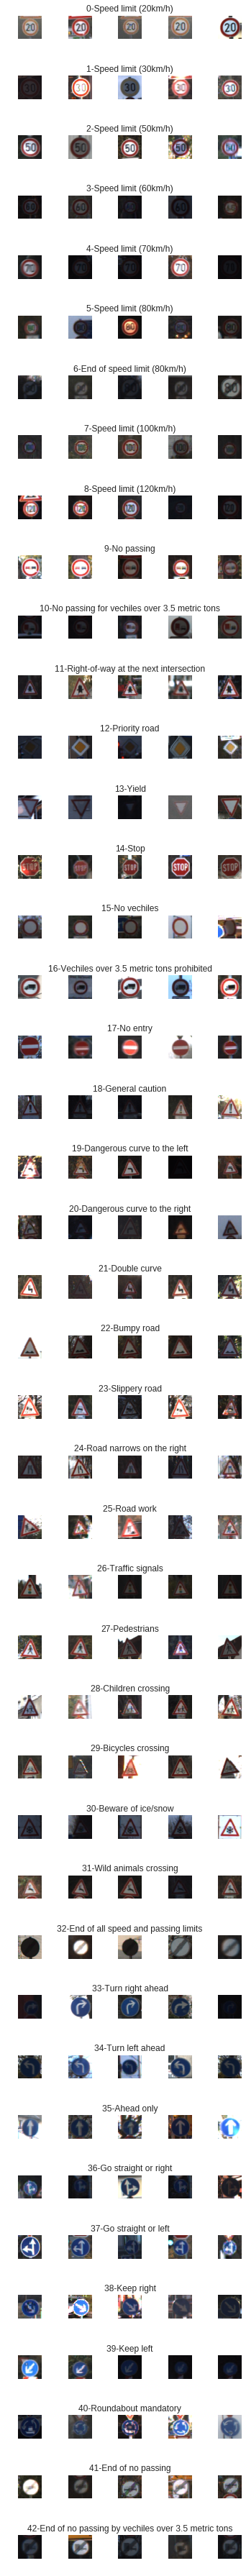

In [7]:
# Analyze the Data
data = pd.read_csv('german-traffic-signs/signnames.csv')
print(data[:10])

num_of_samples = []
 
cols = 5
num_classes = 43
 
fig, axs = plt.subplots(nrows=num_classes, ncols = cols, figsize=(5, 50))
fig.tight_layout()
for i in range(cols):
    for j, row in data.iterrows(): # (index, Series)
        x_selected = X_train[y_train == j]
        axs[j][i].imshow(x_selected[random.randint(0, len(x_selected) - 1), :, :], cmap=plt.get_cmap("gray"))
        axs[j][i].axis("off")
        if i == 2:
            axs[j][i].set_title(str(j) + '-' + row["SignName"])
            num_of_samples.append(len(x_selected))

[180, 1980, 2010, 1260, 1770, 1650, 360, 1290, 1260, 1320, 1800, 1170, 1890, 1920, 690, 540, 360, 990, 1080, 180, 300, 270, 330, 450, 240, 1350, 540, 210, 480, 240, 390, 690, 210, 599, 360, 1080, 330, 180, 1860, 270, 300, 210, 210]


Text(0, 0.5, 'Number of images')

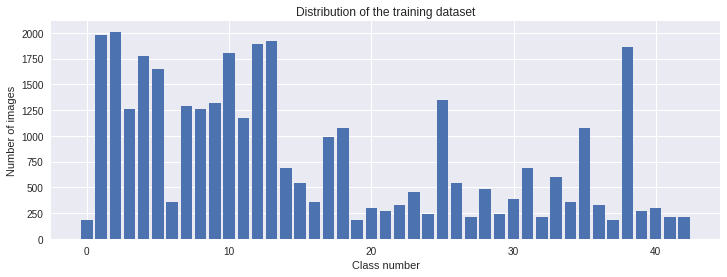

In [8]:
# Print Distribution
print(num_of_samples)
plt.figure(figsize=(12, 4))
plt.bar(range(0, num_classes), num_of_samples)
plt.title("Distribution of the training dataset")
plt.xlabel("Class number")
plt.ylabel("Number of images")

(32, 32, 3)
36


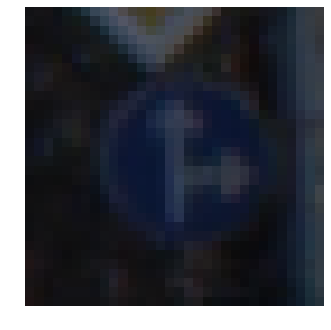

In [9]:
# Preprocess images

import cv2

plt.imshow(X_train[1000])
plt.axis('off')
print(X_train[1000].shape)
print(y_train[1000])

(32, 32)


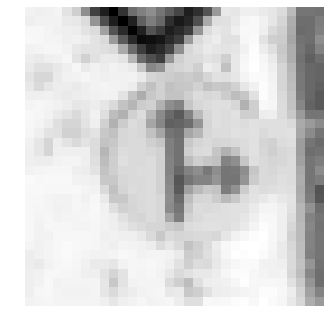

In [10]:
# Grayscaling

def grayscale(img): # convert rgb to grayscale
  img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
  return img

# Test
img = grayscale(X_train[1000])
plt.imshow(img)
plt.axis('off')
print(img.shape)

(32, 32)


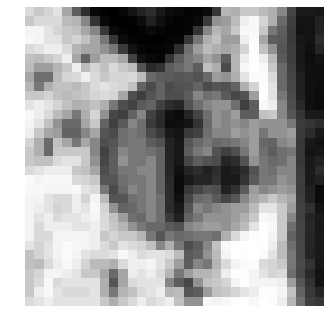

In [11]:
# Equalize the histogram of an image (equalize brighter and darker images)

def equalize(img):
  img = cv2.equalizeHist(img)
  return img

# Test
img = equalize(img)
plt.imshow(img)
plt.axis('off')
print(img.shape)

In [0]:
def preprocessing(img):
  img = grayscale(img)
  img = equalize(img)
  img = img/255 # normalization
  return img

In [0]:
# Preprocess whole data

X_train = np.array(list(map(preprocessing, X_train)))
X_val = np.array(list(map(preprocessing, X_val)))
X_test = np.array(list(map(preprocessing, X_test)))

(34799, 32, 32)


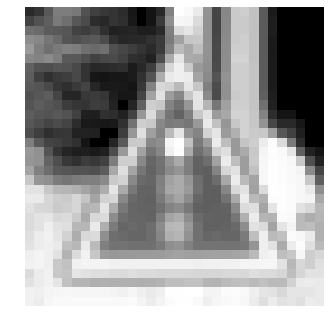

In [14]:
plt.imshow(X_train[random.randint(0, len(X_train) - 1)])
plt.axis('off')
print(X_train.shape)

In [0]:
X_train = X_train.reshape(34799, 32, 32, 1)
X_val = X_val.reshape(4410, 32, 32, 1)
X_test = X_test.reshape(12630, 32, 32, 1)

In [0]:
# Data Augumentation 1/2
from keras.preprocessing.image import ImageDataGenerator

datagen = ImageDataGenerator(width_shift_range=0.1, # 10 = max Value is 10 pixels wide, 0.1 = 10% max Value
                   height_shift_range=0.1,
                   zoom_range=0.2,
                   shear_range=0.1,
                   rotation_range=10)

datagen.fit(X_train) # returns batches when requestet (iterator)

/usr/local/lib/python3.6/dist-packages/matplotlib/tight_layout.py:199: UserWarning: Tight layout not applied. tight_layout cannot make axes width small enough to accommodate all axes decorations
  warnings.warn('Tight layout not applied. '


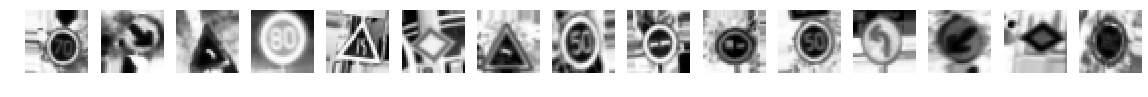

In [116]:
# Data Augumentation 2/2
batches = datagen.flow(X_train, y_train, batch_size=20) # Requesting the generator for images
X_batch, y_batch = next(batches)

fix,axs = plt.subplots(1, 15, figsize=(20, 5))
fig.tight_layout()

for i in range(15):
  axs[i].imshow(X_batch[i].reshape(32, 32))
  axs[i].axis('off')

In [16]:
print(X_train.shape)
print(X_val.shape)
print(X_test.shape)

(34799, 32, 32, 1)
(4410, 32, 32, 1)
(12630, 32, 32, 1)


In [0]:
# One hot-encoding

y_train = to_categorical(y_train, 43)
y_val = to_categorical(y_val, 43)
y_test = to_categorical(y_test, 43)

In [0]:
def modified_model():
  model = Sequential()
  model.add(Conv2D(60, (5,5), input_shape=(32, 32, 1), activation='relu'))
  model.add(Conv2D(60, (5,5), activation='relu'))
  model.add(MaxPooling2D(pool_size=(2,2)))
  model.add(Conv2D(30, (3,3), activation='relu'))
  model.add(Conv2D(30, (3,3), activation='relu'))
  model.add(MaxPooling2D(pool_size=(2,2)))
  model.add(Flatten())
  model.add(Dense(500, activation='relu'))
  model.add(Dropout(0.7))
  model.add(Dense(num_classes, activation='softmax'))
  
  # Compile model
  model.compile(Adam(lr=0.001), loss='categorical_crossentropy', metrics=['accuracy'])
  return model

In [124]:
model = modified_model()
print(model.summary())

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_33 (Conv2D)           (None, 28, 28, 60)        1560      
_________________________________________________________________
conv2d_34 (Conv2D)           (None, 24, 24, 60)        90060     
_________________________________________________________________
max_pooling2d_23 (MaxPooling (None, 12, 12, 60)        0         
_________________________________________________________________
conv2d_35 (Conv2D)           (None, 10, 10, 30)        16230     
_________________________________________________________________
conv2d_36 (Conv2D)           (None, 8, 8, 30)          8130      
_________________________________________________________________
max_pooling2d_24 (MaxPooling (None, 4, 4, 30)          0         
_________________________________________________________________
flatten_12 (Flatten)         (None, 480)               0         
__________

In [125]:
# Training -> Using Datagenerator
history = model.fit_generator(datagen.flow(X_train, y_train, batch_size=50), steps_per_epoch=2000, epochs=10, validation_data=(X_val, y_val), shuffle=True)

Epoch 1/10
2000/2000 [==============================] - 67s 33ms/step - loss: 0.9919 - acc: 0.7111 - val_loss: 0.0998 - val_acc: 0.9696
Epoch 2/10
2000/2000 [==============================] - 64s 32ms/step - loss: 0.2567 - acc: 0.9202 - val_loss: 0.0687 - val_acc: 0.9778
Epoch 3/10
2000/2000 [==============================] - 64s 32ms/step - loss: 0.1674 - acc: 0.9484 - val_loss: 0.0440 - val_acc: 0.9889
Epoch 4/10
2000/2000 [==============================] - 65s 33ms/step - loss: 0.1318 - acc: 0.9595 - val_loss: 0.0353 - val_acc: 0.9912
Epoch 5/10
2000/2000 [==============================] - 65s 32ms/step - loss: 0.1141 - acc: 0.9649 - val_loss: 0.0288 - val_acc: 0.9921
Epoch 6/10
2000/2000 [==============================] - 64s 32ms/step - loss: 0.0968 - acc: 0.9701 - val_loss: 0.0519 - val_acc: 0.9857
Epoch 7/10
2000/2000 [==============================] - 64s 32ms/step - loss: 0.0896 - acc: 0.9729 - val_loss: 0.0307 - val_acc: 0.9918
Epoch 8/10
2000/2000 [==========================

Text(0.5, 0, 'epoch')

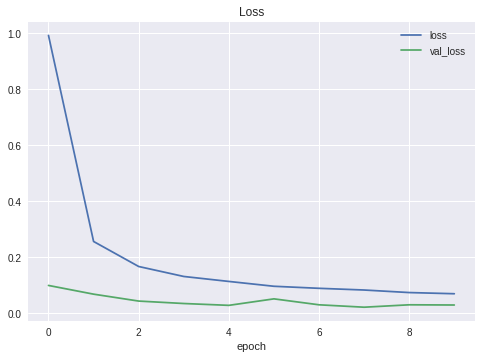

In [126]:
# Plotting
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.legend(['loss', 'val_loss'])
plt.title('Loss')
plt.xlabel('epoch')

Text(0.5, 0, 'epoch')

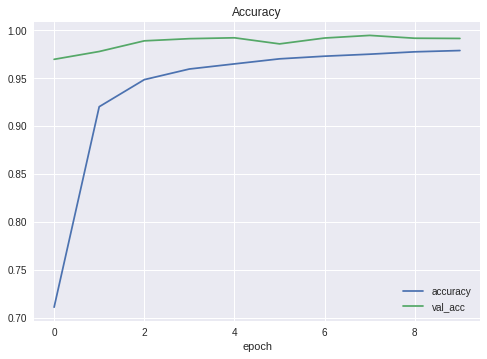

In [127]:
# Plotting
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.legend(['accuracy', 'val_acc'])
plt.title('Accuracy')
plt.xlabel('epoch')

In [128]:
# Evaluation
score = model.evaluate(X_test, y_test, verbose=0)
print('Test Score:', score[0])
print('Test Accuracy:', score[1])

Test Score: 0.1270058884626087
Test Accuracy: 0.9689627870339207


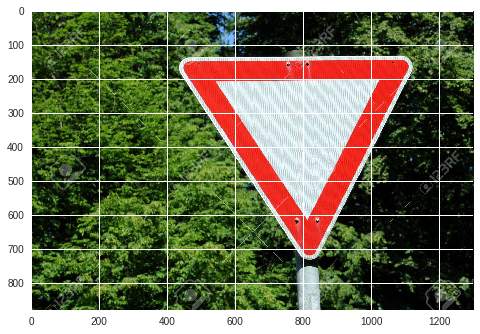

In [129]:
# Fetch image
import requests
from PIL import Image
url = 'https://previews.123rf.com/images/pejo/pejo0907/pejo090700003/5155701-german-traffic-sign-no-205-give-way.jpg'
r = requests.get(url, stream=True)
img = Image.open(r.raw)
plt.imshow(img, cmap=plt.get_cmap('gray'))

(32, 32)


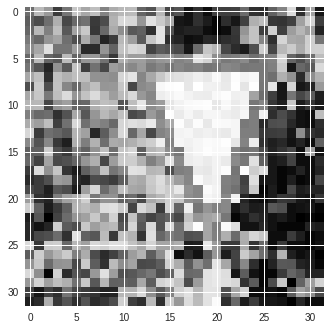

In [130]:
# Preprocess image
img = np.asarray(img)
img = cv2.resize(img, (32, 32))
img = preprocessing(img)
plt.imshow(img, cmap = plt.get_cmap('gray'))
print(img.shape)

In [0]:
# Reshape image
img = img.reshape(1, 32, 32, 1)

In [132]:
# Predict test image
print("predicted sign: "+ str(model.predict_classes(img)))

predicted sign: [13]
